# MBTI - 16 Personalities classifier

# Introduction to the problem
Design and implement a model that given a "post" as input returns the most suited **Myers-Briggs personality type indicator (MBTI)**.

## What is a MBTI
The MBTI (Myers-Briggs Personality Type Indicator) divides everyone into **16 distinct personality** types across **4 axis**:

* Introversion (**I**) – Extroversion (**E**)
* Intuition (**N**) – Sensing (**S**)
* Thinking (**T**) – Feeling (**F**)
* Judging (**J**) – Perceiving (**P**)

This system is used in: *businesses, online, for fun, for research and lots more*.

# Importing Spark (and some other cool things)
Python's imports

In [0]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sparknlp
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [0]:
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import *
import sparknlp
sparknlp.start()

Out[3]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Checking spark is working correctly

In [0]:
spark

Out[20]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# MBTI Dataset

## Downloading the dataset onto the cluster

I hosted the dataset on my [github](https://github.com/edu-rinaldi/MBTI-Predictor/blob/main/dataset/mbti_1.csv.zip), so that I and whoever want to train a different model can download it in an easier way.

In [0]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv

--2021-06-23 08:06:59-- https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/mbti_1.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv [following]
--2021-06-23 08:06:59-- https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/mbti_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62856486 (60M) [text/plain]
Saving to: ‘/tmp/mbti_1.csv’

 0K .......... .......... .......... .......... .......... 0% 5.16M 12s
 50K .......... .......... .......... .......... .......... 0% 4.86M 12s
 100K .......... .......... .......... .......... .......... 0% 4.89M 12s
 150K .......... .......... .......... .......... .......... 0% 4.69M 12s
 200K .......... .......... .......... .......... .......... 0% 5.17M 12s
 250K .......... .......... .......... .......... .......... 0% 5.51M 12s
 300K .......... .......... .......... .......... .......... 0% 24.2M 11s
 350K .......... .......... .......... .......... .......... 0% 44.9M 9s
 400K .......... .......... .......... .......... .......... 0% 8.32M 9s
 450K .......... .......... .......... .......... .......... 0% 39.7M 8s
 500K .......... .......... .......... .......... .......... 0% 40.1M 8s
 550K .......... .......... .......... .......... .......... 0% 30.5M 7s
 600K .......... .......... .......... .......... .......... 1% 75.8M 7s
 650K .......... .......... .......... .......... .......... 1% 11.1M 7s
 700K .......... .......... .......... .......... .......... 1% 34.4M 6s
 750K .......... .......... .......... .......... .......... 1% 141M 6s
 800K .......... .......... .......... .......... .......... 1% 108M 6s
 850K .......... .......... .......... .......... .......... 1% 206M 5s
 900K .......... .......... .......... .......... .......... 1% 58.6M 5s
 950K .......... .......... .......... .......... .......... 1% 102M 5s
 1000K .......... .......... .......... .......... .......... 1% 80.8M 5s
 1050K .......... .......... .......... .......... .......... 1% 11.5M 5s
 1100K .......... .......... .......... .......... .......... 1% 95.7M 4s
 1150K .......... .......... .......... .......... .......... 1% 49.7M 4s
 1200K .......... .......... .......... .......... .......... 2% 67.4M 4s
 1250K .......... .......... .......... .......... .......... 2% 45.6M 4s
 1300K .......... .......... .......... .......... .......... 2% 128M 4s
 1350K .......... .......... .......... .......... .......... 2% 58.7M 4s
 1400K .......... .......... .......... .......... .......... 2% 50.1M 4s
 1450K .......... .......... .......... .......... .......... 2% 45.5M 4s
 1500K .......... .......... .......... .......... .......... 2% 19.7M 4s
 1550K .......... .......... .......... .......... .......... 2% 135M 4s
 1600K .......... .......... .......... .......... .......... 2% 43.3M 3s
 1650K .......... .......... .......... .......... .......... 2% 56.3M 3s
 1700K .......... .......... .......... .......... .......... 2% 53.3M 3s
 1750K .......... .......... .......... .......... .......... 2% 174M 3s
 1800K .......... .......... .......... .......... .......... 3% 55.2M 3s
 1850K .......... .......... .......... .......... .......... 3% 44.9M 3s
 1900K .......... .......... .......... .......... .......... 3% 52.8M 3s
 1950K .......... .......... .......... .......... .......... 3% 18.9M 3s
 2000K .......... .......... .......... .......... .......... 3% 94.3M 3s
 2050K .......... .......... .......... .......... .......... 3% 40.9M 3s
 2100K .......... .......... .......... .......... .......... 3% 77.8M 3s
 2150K ........

### Moving dataset to DBFS

In [0]:
dbutils.fs.mv("file:/tmp/mbti_1.csv", "/bdc-2020-21/datasets/")

Out[22]: True

## Initial dataset analysis

Now that we have downloaded the dataset, let's read it and analyze it

In [0]:
mbti_df = spark.read.load("dbfs:/bdc-2020-21/datasets/mbti_1.csv", 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         ).cache()

### Description of the dataset
This **dataset** contains over **8600 rows of data**, and on each row contains:
* **Type**: 4 letter MBTI code/type
* **Posts**: A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

So after splitting each post we will have about **430k rows**. 

**Acknowledgements:**
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

In [0]:
print(f"The dataset is composed by {len(mbti_df.columns)} columns and {mbti_df.count()} entries/records")
mbti_df.show()

The dataset is composed by 2 columns and 8675 entries/records
+----+--------------------+
type| posts|
+----+--------------------+
INFJ|'http://www.youtu...|
ENTP|'I'm finding the ...|
INTP|'Good one _____ ...|
INTJ|'Dear INTP, I e...|
ENTJ|'You're fired.|||...|
INTJ|'18/37 @.@|||Scie...|
INFJ|'No, I can't draw...|
INTJ|'I tend to build ...|
INFJ|I'm not sure, tha...|
INTP|'https://www.yout...|
INFJ|'One time my pare...|
ENFJ|'https://www.yout...|
INFJ|'Joe santagato - ...|
INTJ|'Fair enough, if ...|
INTP|'Basically this.....|
INTP|'Your comment scr...|
INFJ|'some of these bo...|
INFP|'I think we do ag...|
INFJ|'I fully believe ...|
INFP|'That's normal, i...|
+----+--------------------+
only showing top 20 rows

### Splitting posts by "|||" string and lowering "type"

In [0]:
#mbti_splitted_df = mbti_df.select(explode(split("posts", "\|\|\|")).alias("post"), lower("type").alias("type"))
mbti_splitted_df = mbti_df.select(regexp_replace(col('posts'), "\|\|\|", " ").alias("post"), lower("type").alias("type")).cache()

In [0]:
mbti_splitted_df.withColumn('post_len', length(col('post'))).groupBy('type').agg(avg('post_len').alias('avg'), variance('post_len').alias('variance'), stddev('post_len').alias('stddev')).show(16)

+----+-----------------+------------------+------------------+
type| avg| variance| stddev|
+----+-----------------+------------------+------------------+
estp|6712.921348314607| 2605309.550561798|1614.0971316998855|
entj| 7128.12987012987| 2227617.539582157|1492.5205323821033|
esfj|7306.476190476191|3682000.1579558654|1918.8538657114734|
estj|7042.153846153846|2083510.5020242918|1443.4370447041645|
enfp|7224.551111111111| 2482332.200276954| 1575.541875126445|
istj|7031.736585365854| 2925158.145958872|1710.3093714176018|
enfj|7391.784210526316|2542588.8262044005|1594.5497252216378|
isfj| 7169.77108433735| 3142820.674552757| 1772.800235377003|
istp|6817.780415430267| 2696162.368305779|1641.9995031381036|
intp|7060.151840490797|2506320.2102345214|1583.1361944679686|
infj|7411.125850340136| 2324326.946029739|1524.5743491315006|
intj|7030.890925756187|2764440.0257065734|1662.6605262971073|
isfp| 6663.09594095941| 3004571.672242723|1733.3700332712351|
entp|7014.808759124087|2268123.2338412935|1506.0289618202212|
infp|7221.951419213974|2471062.3488128404| 1571.961306398106|
esfp|5966.395833333333| 4247218.712322694|2060.8781410657675|
+----+-----------------+------------------+------------------+

In [0]:
mbti_splitted_df.withColumn('url_num', size(split(col("post"), r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')) - 1).show()

+--------------------+----+-------+
 post|type|url_num|
+--------------------+----+-------+
'http://www.youtu...|infj| 24|
'I'm finding the ...|entp| 9|
'Good one _____ ...|intp| 4|
'Dear INTP, I e...|intj| 2|
'You're fired. Th...|entj| 6|
'18/37 @.@ Scienc...|intj| 1|
'No, I can't draw...|infj| 2|
'I tend to build ...|intj| 1|
I'm not sure, tha...|infj| 23|
'https://www.yout...|intp| 7|
'One time my pare...|infj| 1|
'https://www.yout...|enfj| 3|
'Joe santagato - ...|infj| 0|
'Fair enough, if ...|intj| 0|
'Basically this.....|intp| 3|
'Your comment scr...|intp| 1|
'some of these bo...|infj| 4|
'I think we do ag...|infp| 0|
'I fully believe ...|infj| 0|
'That's normal, i...|infp| 0|
+--------------------+----+-------+
only showing top 20 rows

In [0]:
url_pattern = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
url_pattern = '\d+(.*?)(?:\u263a|\U0001f645)' # emoji
url_pattern = ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)'
url_pattern = '\?'
c1 = mbti_splitted_df.where(col('post').rlike(url_pattern)).groupBy('type').count()
c2 = mbti_splitted_df.groupBy('type').count()

c1.show(16)
c2.show(16)

+----+-----+
type|count|
+----+-----+
estp| 88|
entj| 229|
esfj| 41|
estj| 39|
enfp| 668|
istj| 203|
enfj| 188|
isfj| 165|
istp| 335|
intp| 1299|
infj| 1454|
intj| 1073|
isfp| 267|
entp| 680|
infp| 1803|
esfp| 47|
+----+-----+

+----+-----+
type|count|
+----+-----+
estp| 89|
entj| 231|
esfj| 42|
estj| 39|
enfp| 675|
istj| 205|
enfj| 190|
isfj| 166|
istp| 337|
intp| 1304|
infj| 1470|
intj| 1091|
isfp| 271|
entp| 685|
infp| 1832|
esfp| 48|
+----+-----+

### Random samples of "exploded" dataset

In [0]:
# printing some basic info
print(f"The dataset is composed by {len(mbti_splitted_df.columns)} columns and {mbti_splitted_df.count()} entries/records")

mbti_splitted_df.show()

The dataset is composed by 2 columns and 8675 entries/records
+--------------------+----+
 post|type|
+--------------------+----+
'http://www.youtu...|infj|
'I'm finding the ...|entp|
'Good one _____ ...|intp|
'Dear INTP, I e...|intj|
'You're fired. Th...|entj|
'18/37 @.@ Scienc...|intj|
'No, I can't draw...|infj|
'I tend to build ...|intj|
I'm not sure, tha...|infj|
'https://www.yout...|intp|
'One time my pare...|infj|
'https://www.yout...|enfj|
'Joe santagato - ...|infj|
'Fair enough, if ...|intj|
'Basically this.....|intp|
'Your comment scr...|intp|
'some of these bo...|infj|
'I think we do ag...|infp|
'I fully believe ...|infj|
'That's normal, i...|infp|
+--------------------+----+
only showing top 20 rows

## Are we dealing with a (Un)balanced Dataset ? 
One of the first things to check is the "density" of each class. 
A balanced dataset makes things easier..

### Counting records for each class

In [0]:
def count_class_instances(df, labelCol, toPandas=True):
  counted_df = df.select(labelCol).groupBy(labelCol).count().sort(labelCol)
  return counted_df.toPandas() if toPandas else counted_df

In [0]:
# Sorting by type because then we could compare this df with another
counted_mbti_types_pdf = count_class_instances(mbti_splitted_df, 'type')

counted_mbti_types_pdf

Out[35]:

,type,count
0,enfj,190
1,enfp,675
2,entj,231
3,entp,685
4,esfj,42
5,esfp,48
6,estj,39
7,estp,89
8,infj,1470
9,infp,1832


### Bar plot about density of each class

Out[36]:

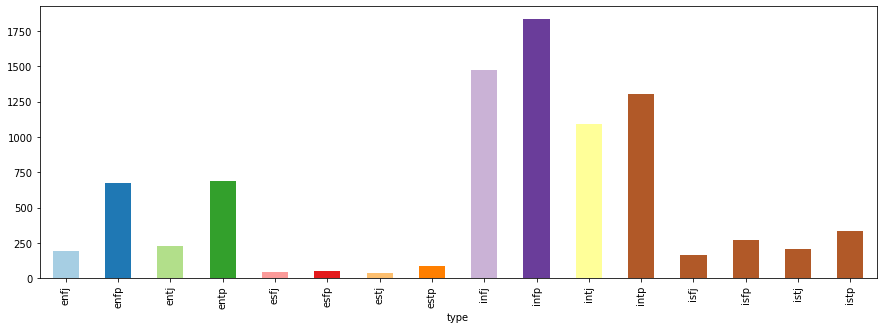

<matplotlib.axes._subplots.AxesSubplot at 0x7f31723a1fd0>

In [0]:
counted_mbti_types_pdf.plot.bar(x='type', y='count', figsize=(15,5), legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))

The first thing that unfortunately we can notice is that the dataset is very **unbalanced**.

The most predominant types are **INxx**, which correspond to introvert personalities; this make me think that on internet (especially on forums and/or social networks) the most predominant personality is the introvert one, so in real world application the model could deal more frequently with **INxx** types.

Another thing to notice is that **Sensing** (**xSxx**) personalities are the less frequents, and that is due to the fact that *Sensors* prefer learning information that they can tangibly apply to their lives. 

But to train in a balanced way our model we must find and then apply some strategies for handling this situation.

## Strategies for dealing with this unbalanced dataset
To deal with this situation we have different options:
1. **Undersampling**: remove instances from most frequent classes until the dataset is balanced
2. **Oversampling**: add synthetical instances of less frequent classes
3. **Collect more data**: we can collect more data of less frequent classes

In this notebook first and third strategies will be applied.

First we will undersample our current dataset so at the end It will be balanced, then using a Reddit scraper that I created, we can scrap new data and so we can create a **new dataset** (that will be presented in the next section) for increasing in a balanced way our "final" dataset size.

At first glance you might think of balancing the dataset only by adding new instances taking them from the new dataset but this could lead to several problems.

The two datasets that we are going to "merge" contain data collected from different "environments" (*PersonalityCafe* for the first one, *Reddit* for the second one), so adding the new data only on the less frequent classes can create differences that the model could interpret and use for classification (wrong, because they are not differences given by the class of the instance, but rather by the environment from which the data were collected)

### Additional strategy: divide type in 4 indicators
Dividing type in 4 indicator ("I/E", "N/S", "T/F", "P/J") brings us different benefits:
1. We can create 4 different models (one for each type indicator), so each model could be optimized for its own target (its own type indicator)
2. We can have 4 different datasets, each one with its own different data. For example in the original dataset if we undersample "INTP" instances because of the N value for "N/S" type indicator, we will undersample also information about the other 3 type indicators values

So the idea is to have at the end 4 different Binary Classifier, and then we can "merge" their results for the "final result"

In [0]:
def split_type(df, typeCol='type', withDrop=False):
  indicators = ['ie', 'ns', 'tf', 'pj']
  splitted_type_df = df
  for i, ind in enumerate(indicators):
    splitted_type_df = splitted_type_df.withColumn(ind, substring(typeCol, i+1, 1))
  if withDrop:
    splitted_type_df = splitted_type_df.drop(typeCol) 
  splitted_type_df = splitted_type_df.cache()
  return splitted_type_df, indicators

In [0]:
mbti_type_splitted_df, indicators = split_type(mbti_splitted_df, withDrop=True)
mbti_type_splitted_df.show()

+--------------------+---+---+---+---+
 post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
'http://www.youtu...| i| n| f| j|
'I'm finding the ...| e| n| t| p|
'Good one _____ ...| i| n| t| p|
'Dear INTP, I e...| i| n| t| j|
'You're fired. Th...| e| n| t| j|
'18/37 @.@ Scienc...| i| n| t| j|
'No, I can't draw...| i| n| f| j|
'I tend to build ...| i| n| t| j|
I'm not sure, tha...| i| n| f| j|
'https://www.yout...| i| n| t| p|
'One time my pare...| i| n| f| j|
'https://www.yout...| e| n| f| j|
'Joe santagato - ...| i| n| f| j|
'Fair enough, if ...| i| n| t| j|
'Basically this.....| i| n| t| p|
'Your comment scr...| i| n| t| p|
'some of these bo...| i| n| f| j|
'I think we do ag...| i| n| f| p|
'I fully believe ...| i| n| f| j|
'That's normal, i...| i| n| f| p|
+--------------------+---+---+---+---+
only showing top 20 rows

### Single type indicator analysis

In [0]:
counted_mbti_pdfs = []
for ind in indicators:
  counted_mbti_pdfs.append(count_class_instances(mbti_type_splitted_df, ind))

Out[13]:

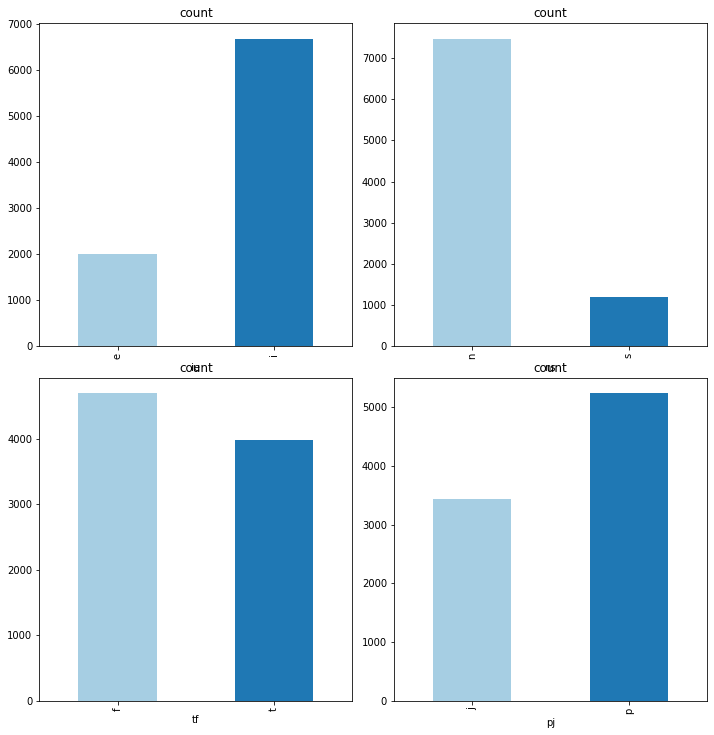

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3172513ca0>],
 dtype=object)

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

counted_mbti_pdfs[0].plot.bar(ax=axes[0,0], subplots=True, x=indicators[0], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_mbti_pdfs[1].plot.bar(ax=axes[0,1], subplots=True, x=indicators[1], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_mbti_pdfs[2].plot.bar(ax=axes[1,0], subplots=True, x=indicators[2], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_mbti_pdfs[3].plot.bar(ax=axes[1,1], subplots=True, x=indicators[3], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))

As we said before the two most unbalanced type indicators are: **"I/E"** and **"N/S"**

# Reddit dataset

It's a **JSONL** dataset containing on each row:
* **Type**: as the MBTI dataset
* **Post**: w.r.t MBTI dataset each line contain a single post

Data has been collected on Reddit using a scraper created by me (code available [here](https://github.com/edu-rinaldi/MBTI-Predictor/tree/main/scraper)).
First thing I collected a list of users (and their respective personality) in 17 subreddits about MBTI ("r/mbti", "r/infp", ...); the personality information is given by a badge that is assigned to the user (and I scraped).

Then, I've scraped the most recent posts of each user (max. 100 for each user) on the **ENTIRE** Reddit platform, so I scraped also posts not related to MBTI.
At the end for each post I assigned the badge (so the personality) related to the author.

## Downloading the dataset

In [0]:
%sh wget -P /tmp https://raw.githubusercontent.com/mahavivo/vocabulary/master/lemmas/AntBNC_lemmas_ver_001.txt

--2021-06-21 13:27:48-- https://raw.githubusercontent.com/mahavivo/vocabulary/master/lemmas/AntBNC_lemmas_ver_001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1348552 (1.3M) [text/plain]
Saving to: ‘/tmp/AntBNC_lemmas_ver_001.txt’

 0K .......... .......... .......... .......... .......... 3% 5.37M 0s
 50K .......... .......... .......... .......... .......... 7% 4.41M 0s
 100K .......... .......... .......... .......... .......... 11% 5.18M 0s
 150K .......... .......... .......... .......... .......... 15% 5.26M 0s
 200K .......... .......... .......... .......... .......... 18% 5.37M 0s
 250K .......... .......... .......... .......... .......... 22% 37.5M 0s
 300K .......... .......... .......... .......... .......... 26% 10.1M 0s
 350K .......... .......... .......... .......... .......... 30% 46.7M 0s
 400K .......... .......... .......... .......... .......... 34% 20.3M 0s
 450K .......... .......... .......... .......... .......... 37% 42.7M 0s
 500K .......... .......... .......... .......... .......... 41% 47.1M 0s
 550K .......... .......... .......... .......... .......... 45% 13.3M 0s
 600K .......... .......... .......... .......... .......... 49% 16.3M 0s
 650K .......... .......... .......... .......... .......... 53% 115M 0s
 700K .......... .......... .......... .......... .......... 56% 104M 0s
 750K .......... .......... .......... .......... .......... 60% 112M 0s
 800K .......... .......... .......... .......... .......... 64% 66.1M 0s
 850K .......... .......... .......... .......... .......... 68% 118M 0s
 900K .......... .......... .......... .......... .......... 72% 118M 0s
 950K .......... .......... .......... .......... .......... 75% 84.2M 0s
 1000K .......... .......... .......... .......... .......... 79% 23.0M 0s
 1050K .......... .......... .......... .......... .......... 83% 88.5M 0s
 1100K .......... .......... .......... .......... .......... 87% 18.3M 0s
 1150K .......... .......... .......... .......... .......... 91% 109M 0s
 1200K .......... .......... .......... .......... .......... 94% 107M 0s
 1250K .......... .......... .......... .......... .......... 98% 100M 0s
 1300K .......... ...... 100% 91.0M=0.08s

2021-06-21 13:27:48 (16.7 MB/s) - ‘/tmp/AntBNC_lemmas_ver_001.txt’ saved [1348552/1348552]

In [0]:
dbutils.fs.mv("file:/tmp/AntBNC_lemmas_ver_001.txt", "/bdc-2020-21/lemmatizer_files/lemmas.txt")

Out[92]: True

In [0]:
%sh wget -P /tmp https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/categorized_posts.tar.gz;
tar xvzf /tmp/categorized_posts.tar.gz -C /tmp/

--2021-06-15 18:34:48-- https://github.com/edu-rinaldi/MBTI-Predictor/raw/main/dataset/categorized_posts.tar.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/categorized_posts.tar.gz [following]
--2021-06-15 18:34:48-- https://raw.githubusercontent.com/edu-rinaldi/MBTI-Predictor/main/dataset/categorized_posts.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59787872 (57M) [application/octet-stream]
Saving to: ‘/tmp/categorized_posts.tar.gz’

 0K .......... .......... .......... .......... .......... 0% 6.96M 8s
 50K .......... .......... .......... .......... .......... 0% 7.48M 8s
 100K .......... .......... .......... .......... .......... 0% 9.57M 7s
 150K .......... .......... .......... .......... .......... 0% 9.04M 7s
 200K .......... .......... .......... .......... .......... 0% 11.5M 7s
 250K .......... .......... .......... .......... .......... 0% 13.6M 6s
 300K .......... .......... .......... .......... .......... 0% 10.4M 6s
 350K .......... .......... .......... .......... .......... 0% 14.9M 6s
 400K .......... .......... .......... .......... .......... 0% 12.1M 6s
 450K .......... .......... .......... .......... .......... 0% 11.7M 6s
 500K .......... .......... .......... .......... .......... 0% 19.6M 5s
 550K .......... .......... .......... .......... .......... 1% 11.3M 5s
 600K .......... .......... .......... .......... .......... 1% 8.74M 5s
 650K .......... .......... .......... .......... .......... 1% 31.7M 5s
 700K .......... .......... .......... .......... .......... 1% 11.7M 5s
 750K .......... .......... .......... .......... .......... 1% 21.1M 5s
 800K .......... .......... .......... .......... .......... 1% 13.1M 5s
 850K .......... .......... .......... .......... .......... 1% 19.8M 5s
 900K .......... .......... .......... .......... .......... 1% 15.1M 5s
 950K .......... .......... .......... .......... .......... 1% 19.5M 5s
 1000K .......... .......... .......... .......... .......... 1% 13.5M 5s
 1050K .......... .......... .......... .......... .......... 1% 23.9M 4s
 1100K .......... .......... .......... .......... .......... 1% 25.8M 4s
 1150K .......... .......... .......... .......... .......... 2% 15.6M 4s
 1200K .......... .......... .......... .......... .......... 2% 19.9M 4s
 1250K .......... .......... .......... .......... .......... 2% 15.4M 4s
 1300K .......... .......... .......... .......... .......... 2% 31.8M 4s
 1350K .......... .......... .......... .......... .......... 2% 15.4M 4s
 1400K .......... .......... .......... .......... .......... 2% 21.5M 4s
 1450K .......... .......... .......... .......... .......... 2% 14.7M 4s
 1500K .......... .......... .......... .......... .......... 2% 38.2M 4s
 1550K .......... .......... .......... .......... .......... 2% 10.6M 4s
 1600K .......... .......... .......... .......... .......... 2% 81.1M 4s
 1650K .......... .......... .......... .......... .......... 2% 29.1M 4s
 1700K .......... .......... .......... .......... .......... 2% 13.9M 4s
 1750K .......... .......... .......... .......... .......... 3% 24.7M 4s
 1800K .......... .......... .......... .......... .......... 3% 13.3M 4s
 1850K .......... .......... .......... .......... .......... 3% 45.4M 4s
 1900K .......... .......... .......... .......... .......... 3% 28.6M 4s
 1950K .......... .......... .......... .......... .......... 3% 29.4M 4s
 2000K .......... .......... .......... .......... .......... 3% 15.9M 4s
 2050K .......... .......... .......... .......... .......... 3% 54.3M 4s
 2100K .......... .

### Move it to DBFS

In [0]:
dbutils.fs.mv("file:/tmp/categorized_posts.json", "/bdc-2020-21/datasets/")

Out[42]: True

### Loading dataset into a Spark dataframe

In [0]:
mbti_reddit_df = spark.read.option("multiLine", "true").json("dbfs:/bdc-2020-21/datasets/categorized_posts.json").cache()
#tmp2 = spark.read.option("multiLine", "true").json("dbfs:/bdc-2020-21/datasets/categorized_posts.json").cache()

In [0]:
tmp = tmp2.groupBy('type').agg( collect_list("post").alias('list') ).collect()

In [0]:
rows = []
cols = ['post', 'type']
for i in range(len(tmp)):
  t = tmp[i].type
  text = []
  for j, post in enumerate(tmp[i].list):
    text.append(post)
    if (j+1) % 30 == 0 or j == len(tmp[i].list) - 1:
      #append
      rows.append((" ".join(text), t))
      #clear text
      text = []
mbti_reddit_df = spark.createDataFrame(rows).toDF(*cols)

In [0]:
mbti_reddit_df.show(5, truncate=True)

+--------------------+----+
 post|type|
+--------------------+----+
[removed] what is...|estp|
hahah yup im musl...|estp|
I wish that were ...|estp|
A few minute Saik...|estp|
Please, I really ...|estp|
+--------------------+----+
only showing top 5 rows

In [0]:
print(f"The dataset is composed by {len(mbti_reddit_df.columns)} columns and {mbti_reddit_df.count()} entries/records")

The dataset is composed by 2 columns and 21602 entries/records

As we can see the dataset is much bigger than the other (200k+ posts), let's see if it has the same type distribution

## Analysis

### Counting records for each type

In [0]:
counted_reddit_types_pdf = count_class_instances(mbti_reddit_df, 'type')
counted_reddit_types_pdf

Out[87]:

,type,count
0,enfj,950
1,enfp,2030
2,entj,1383
3,entp,2064
4,esfj,42
5,esfp,334
6,estj,162
7,estp,709
8,infj,2088
9,infp,2242


### Bar plot about density of each class

Out[88]:

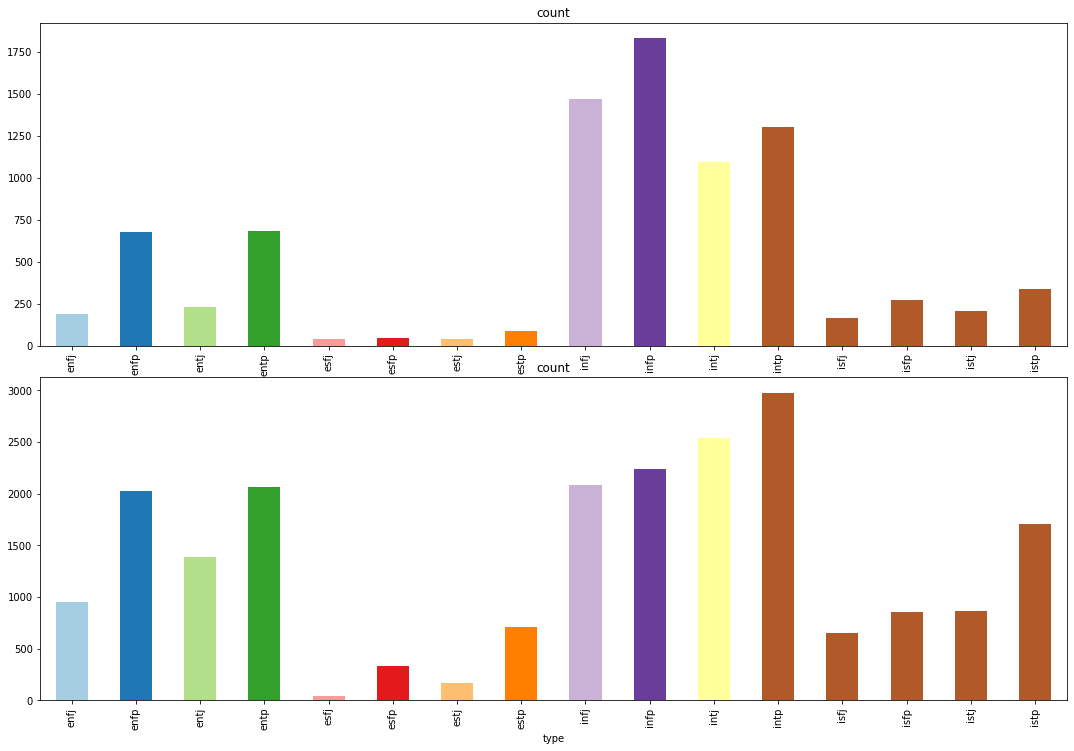

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f451472f610>],
 dtype=object)

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(15,10))
fig.tight_layout()

counted_mbti_types_pdf.plot.bar(ax=axes[0], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_mbti_types_pdf))))
counted_reddit_types_pdf.plot.bar(ax=axes[1], subplots=True, x='type', y='count', legend=False, color=plt.cm.Paired(np.arange(len(counted_reddit_types_pdf))))

On top we have the MBTI dataset, below we have the Reddit dataset.
As we can see the type distribution is very similar.

### Split type in 4 indicators

In [0]:
reddit_splitted_df, _ = split_type(mbti_reddit_df, withDrop=True)
reddit_splitted_df.show()

+--------------------+---+---+---+---+
 post| ie| ns| tf| pj|
+--------------------+---+---+---+---+
they're talking a...| i| s| t| j|
how dare you enjo...| i| s| t| j|
 Alexander Skarsgård| i| s| t| j|
 sigh| i| s| t| j|
Not just regardin...| i| s| t| j|
my school wants u...| i| s| t| j|
All of your famil...| i| s| t| j|
I made Sebastian ...| i| s| t| j|
 we're all dylan| i| s| t| j|
 med bread| i| s| t| j|
 this is pure lunacy| i| s| t| j|
Is it just me tha...| i| s| t| j|
I Wish I Were A M...| i| s| t| j|
I'm sure you guys...| i| s| t| j|
no boy will ever ...| i| s| t| j|
Personally, I wan...| i| s| t| j|
My school will ma...| i| s| t| j|
just did mine for...| i| s| t| j|
what the title sa...| i| s| t| j|
International exa...| i| s| t| j|
+--------------------+---+---+---+---+
only showing top 20 rows

In [0]:
counted_reddit_pdfs = []
for ind in indicators:
  counted_reddit_pdfs.append(count_class_instances(reddit_splitted_df, ind))

Out[91]:

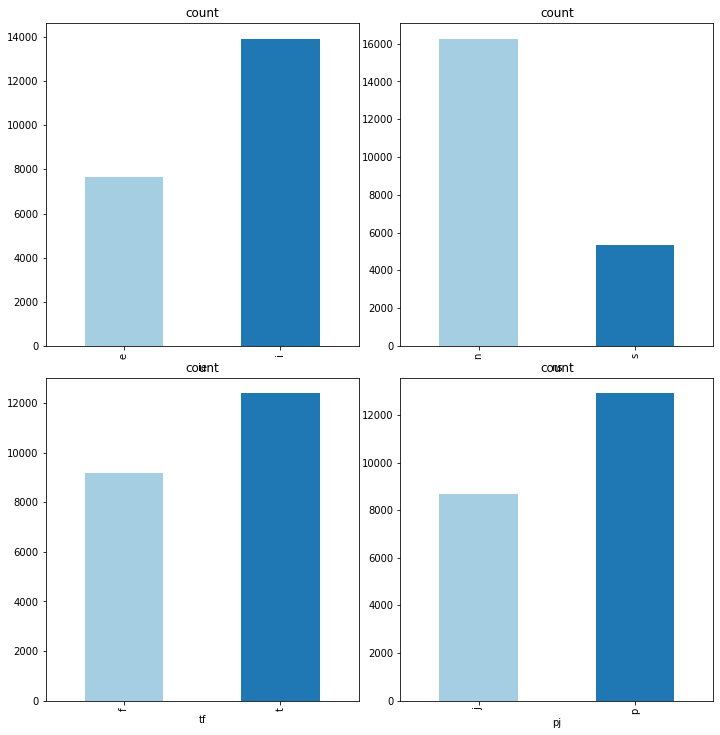

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4514eaad90>],
 dtype=object)

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()

counted_reddit_pdfs[0].plot.bar(ax=axes[0,0], subplots=True, x=indicators[0], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_reddit_pdfs[1].plot.bar(ax=axes[0,1], subplots=True, x=indicators[1], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_reddit_pdfs[2].plot.bar(ax=axes[1,0], subplots=True, x=indicators[2], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))
counted_reddit_pdfs[3].plot.bar(ax=axes[1,1], subplots=True, x=indicators[3], y='count', legend=False, color=plt.cm.Paired(np.arange(2)))

# Data/Text cleaning
Before creating a balanced dataset let's first clean them (some records will be removed, so it's better to balance after)

In [0]:
def clean_text_model(df, inputCol='post'):
  
  normalization_patterns = [
    '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', # url
    ':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)', #emoticons
    '(\[removed\])', # removed reddit instance
    '[^A-Za-z]',
    '([ieIE])([nsNS])([tfTF])([pjPJ])', # remove mbti words
    '([a-z])\1{2,}[\s|\w]*' # remove consecutive single chars
  ]
  
  documentAssembler = DocumentAssembler()\
    .setInputCol("post")\
    .setOutputCol("document")\
    #.setCleanupMode("shrink_full")
  
  tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
  
  normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(normalization_patterns) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])
  
  lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(["normalized"]) \
    .setOutputCol("lemma") \
    #.setDictionary("dbfs:/bdc-2020-21/lemmatizer_files/lemmas.txt", value_delimiter ="\t", key_delimiter = "->")
  
  stopwords_cleaner = StopWordsCleaner().pretrained("stopwords_en", "en")\
      .setInputCols("lemma")\
      .setOutputCol("cleanLemma_1")\
      .setCaseSensitive(False)

  second_stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("cleanLemma_1")\
      .setOutputCol("cleanLemma_2")\
      .setCaseSensitive(False)\
      .setStopWords(['isnt', 'dont', 'ive', 'im', 'arent', 'doesnt', 'havent', 'youre'])
  
  finisher = Finisher() \
    .setInputCols(["cleanLemma_2"]) \
    .setOutputCols(['terms_stemmed']) \
    .setIncludeMetadata(False)
  
  pipeline_stages = [
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    second_stopwords_cleaner,
    finisher
  ]
  clean_pipeline = Pipeline(stages=pipeline_stages)
  pipeline_model = clean_pipeline.fit(df)
  
  # sentence_length_df = pipeline_model.transform(df).withColumn('length', size('terms_stemmed')).cache()
  return pipeline_model

In [0]:
def extract_extra_features(df, inputCol='post', removeEmpty=True):
  
  # number of urls
  num_url_df = df.withColumn('url_num', size(split(col("post"), r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')) - 1)
  # number of emoticons
  num_emoticon_df = num_url_df.withColumn('emoji_num', size(split(col("post"), r':\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\)')) - 1)
  # number of emojis
  # num_emoji_df = num_emoticon_df
  
  # number of '?'
  num_qm_df = num_emoticon_df.withColumn('qm_num', size(split(col("post"), r'\?')) - 1)
  
  # sentence length
  sentence_length_df = num_qm_df.withColumn('length', size('terms_stemmed'))
  
  if removeEmpty:
    return sentence_length_df.where(col('length') > 8).cache()
  else:
    return sentence_length_df.cache()

## Cleaning MBTI dataset

In [0]:
# train/test splitting
train_mbti_df, test_mbti_df = mbti_type_splitted_df.randomSplit([0.7, 0.3])
clean_text_m = clean_text_model(train_mbti_df)
clean_mbti_df = clean_text_m.transform(train_mbti_df).cache()

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ][OK!]
stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[ | ][OK!]

In [0]:
extra_features_mbti_df = extract_extra_features(clean_mbti_df)
extra_features_mbti_df.show()

+--------------------+---+---+---+---+--------------------+-------+---------+------+------+
 post| ie| ns| tf| pj| terms_stemmed|url_num|emoji_num|qm_num|length|
+--------------------+---+---+---+---+--------------------+-------+---------+------+------+
'*looks at the 40...| i| n| t| p|[open, tab, sit, ...| 8| 0| 20| 390|
'*what's things b...| i| n| f| p|[thing, speak, di...| 0| 0| 24| 465|
'... when you don...| e| n| t| p|[start, spend, su...| 0| 6| 5| 453|
'.... ( post dele...| i| n| t| j|[post, delete, st...| 0| 6| 29| 417|
'...Is it possibl...| i| n| f| p|[stop, care, stop...| 0| 3| 6| 527|
'...when you can'...| i| n| t| j|[stop, analyze, t...| 0| 0| 12| 392|
'0 at 29. Can't s...| i| s| t| j|[secret, fact, fa...| 1| 0| 18| 425|
'1) Don't suck at...| i| n| f| p|[suck, die, finis...| 2| 0| 25| 305|
'1) How would you...| i| n| t| p|[classify, drink,...| 1| 1| 11| 478|
'1. As an ENTP fe...| e| n| t| p|[female, prefer, ...| 2| 0| 10| 307|
'1. No. Antitheis...| i| n| t| p|[antitheist, flor...| 0| 2| 18| 480|
'1. What type did...| i| n| t| p|[type, mistype, a...| 0| 0| 15| 508|
'1. What's your M...| i| s| t| p|[myers, briggs, t...| 10| 1| 21| 490|
'15758http://http...| i| n| f| p|[http, darling, b...| 1| 1| 15| 322|
'18/37 @.@ Scienc...| i| n| t| j|[science, perfect...| 1| 0| 10| 495|
'22013 I actuall...| e| n| t| p|[score, bit, libe...| 15| 1| 12| 426|
'288970 It's been...| i| s| t| p|[guy, bleach, hai...| 4| 0| 8| 217|
'29 and still hav...| i| n| f| p|[girlfriend, feel...| 0| 0| 8| 473|
'304242 304250 I...| i| n| f| j|[realistic, weigh...| 2| 2| 10| 412|
'36 Most: 694 or ...| i| n| f| j|[sound, difficult...| 0| 2| 8| 351|
+--------------------+---+---+---+---+--------------------+-------+---------+------+------+
only showing top 20 rows

In [0]:
from pyspark.ml.feature import Word2Vec, CountVectorizer, IDF, PCA 
from pyspark.ml import Pipeline
from pyspark.mllib.linalg import Vectors

countvectorizer = CountVectorizer(inputCol='terms_stemmed', outputCol='cv_features', minDF = 20, vocabSize=6500)
idf = IDF(inputCol="cv_features", outputCol="idf_features")
pca = PCA(k=100, inputCol='idf_features', outputCol='pca_features')
pipeline = Pipeline(stages=[countvectorizer, idf, pca]).fit(extra_features_mbti_df)
pipeline.transform(extra_features_mbti_df).show()
#mat = RowMatrix(pipeline.transform(extra_features_mbti_df))
#svd_model = mat.computeSVD(100, True)

+--------------------+---+---+---+---+--------------------+-------+---------+------+------+--------------------+--------------------+--------------------+
 post| ie| ns| tf| pj| terms_stemmed|url_num|emoji_num|qm_num|length| cv_features| idf_features| pca_features|
+--------------------+---+---+---+---+--------------------+-------+---------+------+------+--------------------+--------------------+--------------------+
'*looks at the 40...| i| n| t| p|[open, tab, sit, ...| 8| 0| 20| 390|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.3802072725903...|
'*what's things b...| i| n| f| p|[thing, speak, di...| 0| 0| 24| 465|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[0.30083320322301...|
'... when you don...| e| n| t| p|[start, spend, su...| 0| 6| 5| 453|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.3768406794809...|
'.... ( post dele...| i| n| t| j|[post, delete, st...| 0| 6| 29| 417|(6500,[0,1,2,4,5,...|(6500,[0,1,2,4,5,...|[-0.4647785140084...|
'...Is it possibl...| i| n| f| p|[stop, care, stop...| 0| 3| 6| 527|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[0.24697124636022...|
'...when you can'...| i| n| t| j|[stop, analyze, t...| 0| 0| 12| 392|(6500,[0,2,3,4,5,...|(6500,[0,2,3,4,5,...|[13.9054984849411...|
'0 at 29. Can't s...| i| s| t| j|[secret, fact, fa...| 1| 0| 18| 425|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.4106782106116...|
'1) Don't suck at...| i| n| f| p|[suck, die, finis...| 2| 0| 25| 305|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.2195425131680...|
'1) How would you...| i| n| t| p|[classify, drink,...| 1| 1| 11| 478|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.5156313739201...|
'1. As an ENTP fe...| e| n| t| p|[female, prefer, ...| 2| 0| 10| 307|(6500,[0,1,2,4,5,...|(6500,[0,1,2,4,5,...|[-0.2086874494581...|
'1. No. Antitheis...| i| n| t| p|[antitheist, flor...| 0| 2| 18| 480|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.6129809584323...|
'1. What type did...| i| n| t| p|[type, mistype, a...| 0| 0| 15| 508|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.7072171480600...|
'1. What's your M...| i| s| t| p|[myers, briggs, t...| 10| 1| 21| 490|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.4884568368715...|
'15758http://http...| i| n| f| p|[http, darling, b...| 1| 1| 15| 322|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.3025578479121...|
'18/37 @.@ Scienc...| i| n| t| j|[science, perfect...| 1| 0| 10| 495|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.6060471695849...|
'22013 I actuall...| e| n| t| p|[score, bit, libe...| 15| 1| 12| 426|(6500,[0,2,3,4,5,...|(6500,[0,2,3,4,5,...|[-0.4048189725964...|
'288970 It's been...| i| s| t| p|[guy, bleach, hai...| 4| 0| 8| 217|(6500,[0,1,2,3,5,...|(6500,[0,1,2,3,5,...|[-0.0916001465985...|
'29 and still hav...| i| n| f| p|[girlfriend, feel...| 0| 0| 8| 473|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.3413410278269...|
'304242 304250 I...| i| n| f| j|[realistic, weigh...| 2| 2| 10| 412|(6500,[0,2,3,4,5,...|(6500,[0,2,3,4,5,...|[-0.4942735838731...|
'36 Most: 694 or ...| i| n| f| j|[sound, difficult...| 0| 2| 8| 351|(6500,[0,1,2,3,4,...|(6500,[0,1,2,3,4,...|[-0.4457847962478...|
+--------------------+---+---+---+---+--------------------+-------+---------+------+------+--------------------+--------------------+--------------------+
only showing top 20 rows

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
va1 = VectorAssembler(inputCols=['pca_features','url_num', 'emoji_num', 'qm_num', 'length'], outputCol='assembled_features')
#va2 = VectorAssembler(inputCols=['pca_features', 'assembled_features1'], outputCol=['assembled_features2'])
ss = StandardScaler(inputCol='assembled_features', outputCol='features')
assembling_scaling_pipeline = Pipeline(stages=[va1, ss]).fit(pipeline.transform(extra_features_mbti_df))

final_df = assembling_scaling_pipeline.transform(pipeline.transform(extra_features_mbti_df))

## Cleaning Reddit dataset

In [0]:
preproc_reddit_df = clean_text(reddit_splitted_df).cache()

preproc_reddit_df.show(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ][OK!]
+--------------------+---+---+---+---+--------------------+
 post| ie| ns| tf| pj| terms_stemmed|
+--------------------+---+---+---+---+--------------------+
[removed] what is...| e| s| t| p|[stereotype, dont...|
hahah yup im musl...| e| s| t| p|[hahah, yup, im, ...|
I wish that were ...| e| s| t| p|[wish, taurus, vi...|
A few minute Saik...| e| s| t| p|[minute, saiki, s...|
Please, I really ...| e| s| t| p|[please, really, ...|
Thank you xDd You...| e| s| t| p|[thank, xdd, mate...|
Thank you! Thank ...| e| s| t| p|[thank, thank, aw...|
Awwe, thank you! ...| e| s| t| p|[awwe, thank, tha...|
There’s never eno...| e| s| t| p|[never, enough, o...|
Damn I’m an estp ...| e| s| t| p|[damn, im, check,...|
+--------------------+---+---+---+---+--------------------+
only showing top 10 rows

# Creating a new balanced dataset
We will procede in 4 slightly different ways for each type indicator.
But in general for each type indicator:
1. Create two new separated dataframes, so one for *mbti dataset* (let's call it `mbti_{ind}_df`) and the other for *reddit dataset* (let's call it `reddit_{ind}_df`)
1. Undersample `mbti_{ind}_df` until is balanced
2. For each value that the type indicator can assume, calculate the maximum number of instances that we can add from `reddit_{ind}_df` to `mbti_{ind}_df` without unbalancing it (let's call this value `N`)
3. Add `2*N` values to `mbti_{ind}_df` (N for each value that can assume the type indicator, in our case only 2 values, e.g. "I/E" can assume only "i" and "e")

In [0]:
def less_frequent_class(df, class_col):
  return df.groupBy(class_col).count().sort('count').collect()[0][class_col]

In [0]:
def undersample(df, ratio, class_col, base_class):
  #base class is the class with less instances
  pos_df = df.filter(col(class_col) == base_class)
  neg_df = df.filter(col(class_col) != base_class)
  total_pos = pos_df.count()
  total_neg = neg_df.count()
  fraction = float(total_pos * ratio)/float(total_neg)
  sampled_df = neg_df.sample(False, fraction)
  return sampled_df.union(pos_df)

## Balancing

In [0]:
mbti_ind_dfs = dict()
reddit_ind_dfs = dict()
for ind in indicators:
  mbti_ind_dfs[ind] = final_df.select('features', ind)
  # reddit_ind_dfs[ind] = preprocd_reddit_df.select('terms_stemmed', ind)

In [0]:
balanced_mbti_ind_dfs = dict()
balanced_reddit_ind_dfs = dict()

for ind in indicators:
  base_class = less_frequent_class(mbti_ind_dfs[ind], ind)
  balanced_mbti_ind_dfs[ind] = undersample(mbti_ind_dfs[ind], 1, ind, base_class)
  base_class = less_frequent_class(reddit_ind_dfs[ind], ind)
  balanced_reddit_ind_dfs[ind] = undersample(reddit_ind_dfs[ind], 1, ind, base_class)

In [0]:
from pyspark.ml.feature import NGram, VectorAssembler
# union
final_dfs = dict()
for ind in indicators:
  #final_dfs[ind] = balanced_reddit_ind_dfs[ind].cache()
  #_2gram = NGram(n=2, inputCol="terms_stemmed", outputCol="2grams")
  #final_dfs[ind] = _2gram.transform(balanced_mbti_ind_dfs[ind].union(balanced_reddit_ind_dfs[ind])).cache()
  #final_dfs[ind] = balanced_mbti_ind_dfs[ind].union(balanced_reddit_ind_dfs[ind])
  final_dfs[ind] = mbti_ind_dfs[ind].union(reddit_ind_dfs[ind])
  #final_dfs[ind] = new_dataset_df.select('features', ind)
  
final_dfs['pj'].show()

+--------------------+---+
 terms_stemmed| pj|
+--------------------+---+
[moment, sportsce...| j|
[im, find, lack, ...| p|
[good, one, cours...| p|
[dear, enjoy, con...| j|
[youre, fire, ano...| j|
[science, perfect...| j|
[cant, draw, nail...| j|
[tend, build, col...| j|
[im, sure, good, ...| j|
[im, position, ac...| p|
[one, time, paren...| j|
[go, break, month...| j|
[joe, santagato, ...| j|
[fair, enough, wa...| j|
[basically, cheez...| p|
[comment, scream,...| p|
[excite, calm, bu...| j|
[think, agree, pe...| p|
[fully, believe, ...| j|
[normal, happen, ...| p|
+--------------------+---+
only showing top 20 rows

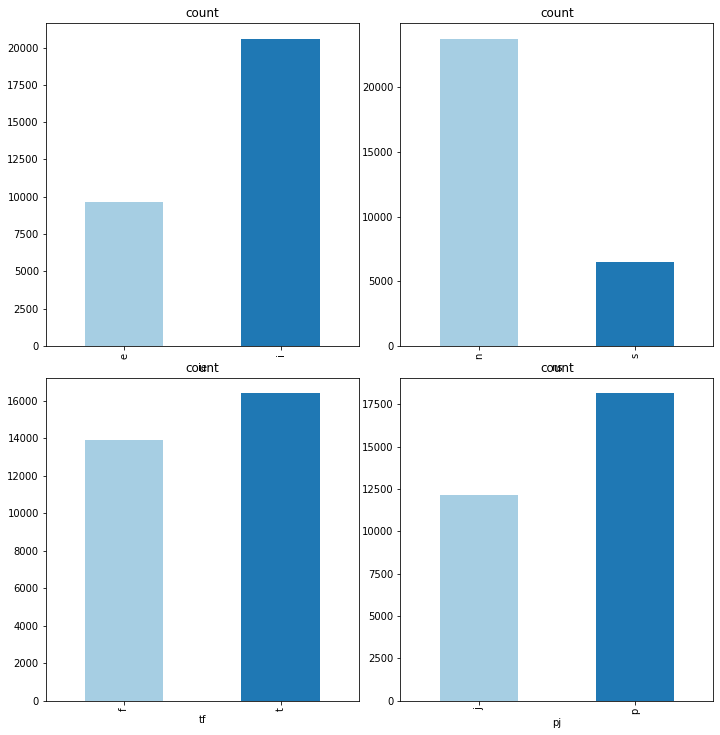

In [0]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 10))
fig.tight_layout()
xy = [(0,0),(0,1),(1,0),(1,1)]
for i, ind in enumerate(indicators):
  x, y = xy[i]
  count_class_instances(final_dfs[ind], ind).plot.bar(ax=axes[x, y], subplots=True, x=ind, y='count', legend=False, color=plt.cm.Paired(np.arange(2)))

# Features learning

In [0]:
EMBEDDING_SIZE = 150 # w2v embedding vector size
RANDOM_SEED = 42
#layers = [104, 16, 16, 16, 2] # nn layers
#layers = [104, 32, 16, 16, 8, 8, 8, 4, 2] # nn layers
layers = [104, 312, 208, 208, 104, 104, 52, 52, 32, 32, 8, 8, 2] # nn layers

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, IndexToString, Word2Vec, CountVectorizer, IDF, PCA, NGram
from pyspark.ml import Pipeline

pipelines = []
for ind in indicators:
  # word2vec feature extraction
  #w2v = Word2Vec(vectorSize=EMBEDDING_SIZE, inputCol='terms_stemmed', outputCol="features", seed=RANDOM_SEED)
  #cv = CountVectorizer(inputCol='terms_stemmed', outputCol="tf_features", vocabSize=50000)
  #idf = IDF(inputCol="tf_features", outputCol="features")
  #pca = PCA(k=K, inputCol="features", outputCol="pca_features")
  # label to index
  labelIndexer = StringIndexer(inputCol=ind, outputCol=f"idx_{ind}")
  
  # model
  nb = NaiveBayes(featuresCol='features',\
                  labelCol=f'idx_{ind}',\
                  predictionCol=f'pred_{ind}',\
                  modelType='multinomial')
  
  svc = LinearSVC(featuresCol='features',\
                  labelCol=f'idx_{ind}',\
                  predictionCol=f'pred_{ind}')
                  
  
  rf = RandomForestClassifier(featuresCol='features',\
                              labelCol=f'idx_{ind}',\
                              predictionCol=f'pred_{ind}',\
                              seed=RANDOM_SEED)
  
  nn = MultilayerPerceptronClassifier(labelCol=f"idx_{ind}",\
                                      featuresCol="features",\
                                      predictionCol=f"pred_{ind}",\
                                      #rawPredictionCol=f"raw_pred_{ind}",\
                                      #probabilityCol=f'p_{ind}',\
                                      maxIter=100,\
                                      layers=layers,\
                                      seed=RANDOM_SEED)
  # indexed prediction to label
  labelConverter = IndexToString(inputCol=f"pred_{ind}", outputCol=f"labeled_pred_{ind}", labels=[ind[0], ind[1]])
  pipeline_stages = [
    #w2v,
    #cv, 
    #idf,
    #pca,
    labelIndexer, 
    #rf,
    svc,
    #nn,
    labelConverter
  ]
  pipelines += [Pipeline(stages=pipeline_stages)]
  #pipelines += [Pipeline(stages=[w2v, labelIndexer, nb, labelConverter])]

In [0]:
#models = [pipelines[i].fit(train_dfs[ind]) for i, ind in enumerate(indicators)]
models = []
for i, ind in enumerate(indicators):
  models.append(pipelines[i].fit(mbti_ind_dfs[ind]))
  print(i)
  

0
1
2
3

In [0]:
clean_test_mbti_df = clean_text_m.transform(test_mbti_df).cache()
test_extra_features_mbti_df = extract_extra_features(clean_test_mbti_df).cache()
test_final_df = assembling_scaling_pipeline.transform(pipeline.transform(test_extra_features_mbti_df)).cache()

In [0]:
predictions = dict()
for i, ind in enumerate(indicators):
  prediction = models[i].transform(test_final_df.select('features', ind).cache())
  predictions[ind] = prediction
  prediction.show(100)

+--------------------+---+------+--------------------+-------+---------------+
 features| ie|idx_ie| rawPrediction|pred_ie|labeled_pred_ie|
+--------------------+---+------+--------------------+-------+---------------+
[0.04042092459903...| i| 0.0|[0.94531261049219...| 0.0| i|
[-0.0133814530428...| i| 0.0|[1.05655790705875...| 0.0| i|
[-0.0472387630171...| e| 1.0|[0.94433692061613...| 0.0| i|
[0.01969098698784...| i| 0.0|[1.05715111907350...| 0.0| i|
[-0.0019472159759...| i| 0.0|[1.15712434218581...| 0.0| i|
[-0.0305288603108...| i| 0.0|[1.11154786291954...| 0.0| i|
[-0.0221486499556...| i| 0.0|[1.04153493400788...| 0.0| i|
[-0.0257590535489...| i| 0.0|[0.97792833677453...| 0.0| i|
[-0.0388345593846...| e| 1.0|[0.81699088401630...| 0.0| i|
[-0.0354431205174...| e| 1.0|[1.13616741470028...| 0.0| i|
[0.05239622044435...| i| 0.0|[1.00568025410492...| 0.0| i|
[-0.0427145013307...| i| 0.0|[0.94758737390472...| 0.0| i|
[-0.0202808323375...| i| 0.0|[0.93487223816127...| 0.0| i|
[-0.0533035597201...| e| 1.0|[1.14570503930572...| 0.0| i|
[-0.0375205946269...| i| 0.0|[1.06703775888499...| 0.0| i|
[-0.0322696090399...| e| 1.0|[0.94903207861232...| 0.0| i|
[-0.0579584070663...| i| 0.0|[1.04567080916774...| 0.0| i|
[-0.0381596755792...| i| 0.0|[1.04377032823550...| 0.0| i|
[-0.0839769680699...| i| 0.0|[1.07827352248030...| 0.0| i|
[-0.0272051694577...| i| 0.0|[1.13233848407386...| 0.0| i|
[0.04596429893364...| i| 0.0|[0.94547349930604...| 0.0| i|
[-0.0392987342752...| i| 0.0|[1.20880769892275...| 0.0| i|
[-0.0399981587195...| i| 0.0|[0.95836354080083...| 0.0| i|
[0.03082071293736...| i| 0.0|[1.12151910451773...| 0.0| i|
[0.02887183231844...| i| 0.0|[1.08797751769046...| 0.0| i|
[-0.0433772312774...| i| 0.0|[1.06823518795305...| 0.0| i|
[-0.0390133667068...| i| 0.0|[0.97081824976955...| 0.0| i|
[2.61284962529995...| i| 0.0|[1.07524177684622...| 0.0| i|
[-0.0306719889458...| i| 0.0|[1.01918433187085...| 0.0| i|
[0.03004479576160...| i| 0.0|[0.87508319797125...| 0.0| i|
[-0.0369482210802...| e| 1.0|[0.98876059620934...| 0.0| i|
[-0.0169044731576...| i| 0.0|[0.97352121292954...| 0.0| i|
[0.04850691899700...| e| 1.0|[0.85378180444943...| 0.0| i|
[-0.0333194117148...| e| 1.0|[0.89720114581023...| 0.0| i|
[-0.0451940317112...| i| 0.0|[0.99139483441933...| 0.0| i|
[-0.0325429550624...| e| 1.0|[1.03802127474581...| 0.0| i|
[-0.0753279358018...| i| 0.0|[1.06884921191513...| 0.0| i|
[-0.0607897935899...| i| 0.0|[1.19147392742475...| 0.0| i|
[-0.0541521229232...| i| 0.0|[0.99773604499180...| 0.0| i|
[0.03478243344951...| e| 1.0|[0.87811139338112...| 0.0| i|
[-0.0504762098841...| i| 0.0|[0.89776034171665...| 0.0| i|
[-0.0512984834311...| e| 1.0|[0.95424479071788...| 0.0| i|
[-0.0523463924952...| e| 1.0|[1.07780868287713...| 0.0| i|
[0.18976034682492...| i| 0.0|[0.94859860493161...| 0.0| i|
[-0.0697540101263...| i| 0.0|[1.24202704110244...| 0.0| i|
[-0.0267776115705...| i| 0.0|[1.04800982642288...| 0.0| i|
[-0.0587662081422...| i| 0.0|[1.04648185566548...| 0.0| i|
[-0.0273892336205...| i| 0.0|[0.96322442472069...| 0.0| i|
[-0.0347031836177...| i| 0.0|[1.12710444531780...| 0.0| i|
[-0.0533789779211...| i| 0.0|[1.01029123993510...| 0.0| i|
[-0.0244115379612...| i| 0.0|[1.02331293905435...| 0.0| i|
[-0.0332500038881...| i| 0.0|[1.25223491618236...| 0.0| i|
[-0.0612550126954...| e| 1.0|[1.01185149918087...| 0.0| i|
[0.02961066506472...| i| 0.0|[1.01631620292184...| 0.0| i|
[-0.0512792299379...| e| 1.0|[0.99277710746178...| 0.0| i|
[-0.0478172134747...| i| 0.0|[1.12835560275736...| 0.0| i|
[-0.0390803680460...| e| 1.0|[1.08120612276511...| 0.0| i|
[0.07187581335359...| i| 0.0|[1.01334365652690...| 0.0| i|
[0.04518453832248...| i| 0.0|[0.86427985293934...| 0.0| i|
[0.00735057215880...| e| 1.0|[1.00982647047696...| 0.0| i|
[-0.0661669932384...| e| 1.0|[0.70947488763562...| 0.0| i|
[-0.0390492863025...| i| 0.0|[1.07809474265870...| 0.0| i|
[-0.0479250208083...| i| 0.0|[0.82158061927852...| 0.0| i|
[-0.0473356235952...| i| 0.0|[0.99036127742480...| 0.0| i|
[-0.0

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
metric_name = "weightedRecall"
for i, ind in enumerate(indicators):
  evaluator = MulticlassClassificationEvaluator(labelCol=f"idx_{ind}", predictionCol=f"pred_{ind}", metricName=metric_name)
  accuracy = evaluator.evaluate(predictions[ind])
  print(f"Predictions for {ind} {metric_name} = %g, Test Error = %g" % (accuracy, (1.0 - accuracy)))
  

Predictions for ie weightedRecall = 0.78149, Test Error = 0.21851
Predictions for ns weightedRecall = 0.863671, Test Error = 0.136329
Predictions for tf weightedRecall = 0.792243, Test Error = 0.207757
Predictions for pj weightedRecall = 0.658218, Test Error = 0.341782

# AAAAA

In [0]:
%sh wget -P /tmp https://www.kaggleusercontent.com/kf/45775676/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..xqzNYQKUNNEFcVQmw9TZ2g.VP6Lal3yCtIBFMoXPaOJFKeJftPw8rDskIa3fOFuPxDO2SCqN91UB1faF5JWVOPqlbCooJI3MWk-3o1pJDeMgRrDRT-VKh4Kyx-XgcKEBKOnydtcgG7Gmp1S7N4-sbmr1AXVl-b3AMLNH6RvZEgphd7_F1Z1793f5AS7jgszVvDPOoagelHnziI5_Z2a9u8Toior20uHjl3E88hFViwBSWc0oDeYi2oh83Do27iRYYDz9KOCnA4-AOSuBlm5p2GFNxFk1YFDSZ8zWCxoZQAFRmmaWu4gib_Iw30GVLYfwdJNtZMGRHrvIBCsSQanueaEUzq0gwhOsi2XchpItWlE1DjxE1B_zXdAxYuPb8_nx0NFUDFDGkc83eenWjtfGCfWw8sOG-9iAg6pdwCb-Sr8fAVA52h_GljosDjbx9ZvWQ67wrRFo5Fqu2K5U5qYUKTXH809MMcNwFtLWPQj8khqUeNjte3D5FnkxsYXqKhf2J7ZSVdYuI-yV_WxwisZf_SnAiCIEiC8jmaqleyqM8ks7xEpSjy5aIozfEUJ30IAqXZNVZ1RUBisdlACF792Dm8QoGPaOqJsNRdLTyzJH-b_VoRcC66iqeCtuUFVbzXvu3D9WuroNJXLarevqrvOWCytkSzfx5jV7mBcceg7Cxql_1roZfhfYi3OHRoMClj8BD8.CcHK24qDMscWTNESIRu1wg/result_svd_vec_dimensions.csv

--2021-06-21 16:55:06-- https://www.kaggleusercontent.com/kf/45775676/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..xqzNYQKUNNEFcVQmw9TZ2g.VP6Lal3yCtIBFMoXPaOJFKeJftPw8rDskIa3fOFuPxDO2SCqN91UB1faF5JWVOPqlbCooJI3MWk-3o1pJDeMgRrDRT-VKh4Kyx-XgcKEBKOnydtcgG7Gmp1S7N4-sbmr1AXVl-b3AMLNH6RvZEgphd7_F1Z1793f5AS7jgszVvDPOoagelHnziI5_Z2a9u8Toior20uHjl3E88hFViwBSWc0oDeYi2oh83Do27iRYYDz9KOCnA4-AOSuBlm5p2GFNxFk1YFDSZ8zWCxoZQAFRmmaWu4gib_Iw30GVLYfwdJNtZMGRHrvIBCsSQanueaEUzq0gwhOsi2XchpItWlE1DjxE1B_zXdAxYuPb8_nx0NFUDFDGkc83eenWjtfGCfWw8sOG-9iAg6pdwCb-Sr8fAVA52h_GljosDjbx9ZvWQ67wrRFo5Fqu2K5U5qYUKTXH809MMcNwFtLWPQj8khqUeNjte3D5FnkxsYXqKhf2J7ZSVdYuI-yV_WxwisZf_SnAiCIEiC8jmaqleyqM8ks7xEpSjy5aIozfEUJ30IAqXZNVZ1RUBisdlACF792Dm8QoGPaOqJsNRdLTyzJH-b_VoRcC66iqeCtuUFVbzXvu3D9WuroNJXLarevqrvOWCytkSzfx5jV7mBcceg7Cxql_1roZfhfYi3OHRoMClj8BD8.CcHK24qDMscWTNESIRu1wg/result_svd_vec_dimensions.csv
Resolving www.kaggleusercontent.com (www.kaggleusercontent.com)... 35.190.26.106
Connecting to www.kaggleusercontent.com (www.kaggleusercontent.com)|35.190.26.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17135314 (16M) [application/octet-stream]
Saving to: ‘/tmp/result_svd_vec_dimensions.csv’

 0K .......... .......... .......... .......... .......... 0% 4.29M 4s
 50K .......... .......... .......... .......... .......... 0% 794K 12s
 100K .......... .......... .......... .......... .......... 0% 6.43M 9s
 150K .......... .......... .......... .......... .......... 1% 6.71M 7s
 200K .......... .......... .......... .......... .......... 1% 7.89M 6s
 250K .......... .......... .......... .......... .......... 1% 28.4M 5s
 300K .......... .......... .......... .......... .......... 2% 32.6M 5s
 350K .......... .......... .......... .......... .......... 2% 22.4M 4s
 400K .......... .......... .......... .......... .......... 2% 15.9M 4s
 450K .......... .......... .......... .......... .......... 2% 33.5M 3s
 500K .......... .......... .......... .......... .......... 3% 33.1M 3s
 550K .......... .......... .......... .......... .......... 3% 34.7M 3s
 600K .......... .......... .......... .......... .......... 3% 25.9M 3s
 650K .......... .......... .......... .......... .......... 4% 29.0M 3s
 700K .......... .......... .......... .......... .......... 4% 16.7M 2s
 750K .......... .......... .......... .......... .......... 4% 14.7M 2s
 800K .......... .......... .......... .......... .......... 5% 16.7M 2s
 850K .......... .......... .......... .......... .......... 5% 13.7M 2s
 900K .......... .......... .......... .......... .......... 5% 19.9M 2s
 950K .......... .......... .......... .......... .......... 5% 15.8M 2s
 1000K .......... .......... .......... .......... .......... 6% 18.8M 2s
 1050K .......... .......... .......... .......... .......... 6% 13.4M 2s
 1100K .......... .......... .......... .......... .......... 6% 16.9M 2s
 1150K .......... .......... .......... .......... .......... 7% 17.1M 2s
 1200K .......... .......... .......... .......... .......... 7% 12.0M 2s
 1250K .......... .......... .......... .......... .......... 7% 12.1M 2s
 1300K .......... .......... .......... .......... .......... 8% 32.2M 2s
 1350K .......... .......... .......... .......... .......... 8% 19.0M 2s
 1400K .......... .......... .......... .......... .......... 8% 12.9M 2s
 1450K .......... .......... .......... .......... .......... 8% 15.9M 2s
 1500K .......... .......... .......... .......... .......... 9% 18.6M 2s
 1550K .......... .......... .......... .......... .......... 9% 16.4M 2s
 1600K .......... .......... .......... .......... .......... 9% 13.4M 2s
 1650K .......... .......... .......... .......... .......... 10% 12.6M 2s
 1700K .......... .......... .......... .......... .......... 10% 25.2M 2s
 1750K .......... .......... .......... .......... .......... 10% 17.3M 1s
 1800K .......... .......... .......... .......... .......... 11% 9.90M 1s
 1850K .......... .......... .......... .......... .......... 11% 27.7M 1s